In [1]:
import os

In [2]:
os.listdir('/nobackup/users/nolangc')

['writer.log',
 'datasets',
 'i-jepa',
 'mp16',
 'mp16.zip',
 'Anaconda3-2022.05-Linux-ppc64le.sh',
 'anaconda3']

In [3]:
import os
import argparse
import re
from typing import Union
from io import BytesIO
import random
from pathlib import Path

from PIL import Image
import torchvision
import torch
import msgpack
from torchvision.transforms import Compose, Resize, ToTensor
from src.transforms import make_transforms

from tqdm import tqdm
from src.transforms import make_transforms # IMPORT transforms.py CORRECTLY HERE

# just taken from original script
crop_size = 224
crop_scale = [0.8, 1.0]
use_gaussian_blur = False
use_horizontal_flip = False
use_color_distortion = False
color_jitter = 0.0

class MsgPackIterableDataset(torch.utils.data.IterableDataset):
    def __init__(
        self,
        path: str,
        key_img_id: str = "id",
        key_img_encoded: str = "image",
        transformation=None,
        shuffle=False,
        cache_size=6 * 4096,
    ):

        super(MsgPackIterableDataset, self).__init__()
        self.path = path
        self.cache_size = cache_size
        self.transformation = transformation
        self.shuffle = shuffle
        self.seed = random.randint(1, 100)
        self.key_img_id = key_img_id.encode("utf-8")
        self.key_img_encoded = key_img_encoded.encode("utf-8")

        if not isinstance(self.path, (list, set)):
            self.path = [self.path]
        
        self.shards = self.__init_shards(self.path)

    @staticmethod
    def __init_shards(path: Union[str, Path]) -> list:
        shards = []
        for i, p in enumerate(path):
            shards_re = r"shard_(\d+).msg"
            shards_index = [
                int(re.match(shards_re, x).group(1))
                for x in os.listdir(p)
                if re.match(shards_re, x)
            ]
            shards.extend(
                [
                    {
                        "path_index": i,
                        "path": p,
                        "shard_index": s,
                        "shard_path": os.path.join(p, f"shard_{s}.msg"),
                    }
                    for s in shards_index
                ]
            )
        if len(shards) == 0:
            raise ValueError("No shards found")
        
        return shards

    def _process_sample(self, x):
        img = Image.open(BytesIO(x[self.key_img_encoded]))
        if img.mode != "RGB":
            img = img.convert("RGB")
        
        if self.transformation is not None:
            img = self.transformation(img)
        
        _id = x[self.key_img_id].decode("utf-8")
        return img, _id

    def __iter__(self):

        shard_indices = list(range(len(self.shards)))

        if self.shuffle:
            random.seed(self.seed)
            random.shuffle(shard_indices)

        worker_info = torch.utils.data.get_worker_info()

        if worker_info is not None:

            def split_list(alist, splits=1):
                length = len(alist)
                return [
                    alist[i * length // splits : (i + 1) * length // splits]
                    for i in range(splits)
                ]

            shard_indices_split = split_list(shard_indices, worker_info.num_workers)[
                worker_info.id
            ]

        else:
            shard_indices_split = shard_indices

        cache = []

        for shard_index in shard_indices_split:
            shard = self.shards[shard_index]

            with open(
                os.path.join(shard["path"], f"shard_{shard['shard_index']}.msg"), "rb"
            ) as f:
                unpacker = msgpack.Unpacker(
                    f, max_buffer_size=1024 * 1024 * 1024, raw=True
                )
                for x in unpacker:
                    if x is None:
                        continue

                    if len(cache) < self.cache_size:
                        cache.append(x)

                    if len(cache) == self.cache_size:

                        if self.shuffle:
                            random.shuffle(cache)
                        while cache:
                            yield self._process_sample(cache.pop())
        if self.shuffle:
            random.shuffle(cache)

        while cache:
            yield self._process_sample(cache.pop())

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Training

### Create MaskCollator

In [6]:
from src.masks.multiblock import MaskCollator as MBMaskCollator

pred_mask_scale = [0.15, 0.2]
enc_mask_scale = [0.85, 1]
aspect_ratio = [0.75, 1.5]
num_enc_masks = 1
num_pred_masks = 4
allow_overlap = False
min_keep = 10


mask_collator = MBMaskCollator(
    input_size=224,
    patch_size=14,
    pred_mask_scale=pred_mask_scale,
    enc_mask_scale=enc_mask_scale,
    aspect_ratio=aspect_ratio,
    nenc=num_enc_masks,
    npred=num_pred_masks,
    allow_overlap=allow_overlap,
    min_keep=min_keep)

### Create Transform

In [7]:
from src.transforms import make_transforms

crop_size = 224
crop_scale = [0.8, 1.0]
use_gaussian_blur = False
use_horizontal_flip = False
use_color_distortion = False
color_jitter = 0.0

transform = make_transforms(
    crop_size=crop_size,
    crop_scale=crop_scale,
    gaussian_blur=use_gaussian_blur,
    horizontal_flip=use_horizontal_flip,
    color_distortion=use_color_distortion,
    color_jitter=color_jitter)

### Mask Helpers

In [8]:
from src.utils.distributed import (
    init_distributed,
    AllReduce
)
def apply_masks(x, masks):
    """
    :param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep
    """
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)
def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x

In [37]:
def make_mp16(
    transform,
    batch_size,
    root,
    collator=None,
    pin_mem=True,
    num_workers=8,
    world_size=1,
    rank=0,
    drop_last=True,
):
    dataset = MsgPackIterableDataset(path=root, transformation=transform)
    #logger.info('MP16 dataset created')
    data_loader = torch.utils.data.DataLoader(
        dataset,
        collate_fn=collator,
        batch_size=batch_size,
        drop_last=drop_last,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=False)
    #logger.info('MP16 unsupervised data loader created')
    return dataset, data_loader

In [38]:
#Placeholders, not an issue once we transplant into the main script
num_workers = 4
world_size = 1
rank = 0
pin_mem = False

_, unsupervised_loader = make_mp16(
        transform=transform,
        batch_size=16,
        collator=mask_collator,
        root='/nobackup/users/nolangc/mp16',
        pin_mem=pin_mem,
        num_workers=num_workers,
        world_size=world_size,
        rank=rank,
        drop_last=True)

In [39]:
for itr, (udata, masks_enc, masks_pred) in enumerate(unsupervised_loader):
    print(udata[0], masks_enc, masks_pred)
    break

tensor([[[[-0.6965, -0.6965, -0.6965,  ..., -0.2513, -0.2513, -0.2342],
          [-0.6965, -0.6965, -0.6965,  ..., -0.2513, -0.2513, -0.2342],
          [-0.6965, -0.6965, -0.6965,  ..., -0.2513, -0.2513, -0.2342],
          ...,
          [-0.0458, -0.2513, -0.3198,  ..., -0.5767, -0.5424, -0.4911],
          [-0.3369, -0.3198, -0.1828,  ..., -0.4568, -0.4911, -0.5253],
          [-0.3027, -0.1486,  0.0227,  ..., -0.5082, -0.4397, -0.4739]],

         [[ 0.1352,  0.1352,  0.1352,  ...,  0.6078,  0.6078,  0.6254],
          [ 0.1352,  0.1352,  0.1352,  ...,  0.6078,  0.6078,  0.6254],
          [ 0.1352,  0.1352,  0.1352,  ...,  0.6078,  0.6078,  0.6254],
          ...,
          [ 1.2906,  1.0805,  1.0105,  ...,  0.6254,  0.6604,  0.7129],
          [ 0.9930,  1.0105,  1.1506,  ...,  0.7479,  0.7479,  0.7129],
          [ 1.0280,  1.1856,  1.3606,  ...,  0.7304,  0.8004,  0.7654]],

         [[ 1.1237,  1.1237,  1.1237,  ...,  1.4897,  1.4897,  1.5071],
          [ 1.1237,  1.1237,  

### Initialize Imagenet Checkpoint

In [40]:
checkpoint_path = "/nobackup/users/nolangc/i-jepa/22k.pth.tar"

In [41]:
from src.helper import init_model

encoder, predictor = init_model(
    device="cuda:0",
    patch_size=14,
    model_name='vit_huge',
    crop_size=224,
    pred_depth=12,
    pred_emb_dim=384
)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)


### Init Optim

In [42]:
from src.helper import init_opt
optimizer, scaler, scheduler, wd_scheduler = init_opt(
    encoder,
    predictor,
    iterations_per_epoch=1, #?
    start_lr=0.0002,
    ref_lr=0.001, #?
    warmup=40,
    num_epochs=300,
    wd=1e-6,
    final_wd=1e-6,
    final_lr=1.0e-06,
    use_bfloat16=False,
    ipe_scale=1.0
)

INFO:root:Using AdamW


### Target Encoder is a copy of Encoder

In [43]:
import copy
target_encoder = copy.deepcopy(encoder)

### Load Checkpoint using Patched Function

In [44]:
"""
https://github.com/facebookresearch/ijepa/issues/50
"""
def load_checkpoint_PATCHED(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        for k, v in pretrained_dict.items():
            encoder.state_dict()[k[len("module."):]].copy_(v)
        print(f'loaded pretrained encoder from epoch {epoch}')
        
        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        for k, v in pretrained_dict.items():
            predictor.state_dict()[k[len("module."):]].copy_(v)
        print(f'loaded pretrained encoder from epoch {epoch}')
        
        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            for k, v in pretrained_dict.items():
                target_encoder.state_dict()[k[len("module."):]].copy_(v)
            print(f'loaded pretrained encoder from epoch {epoch}')
        
        # -- loading optimizer
        opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        print(f'loaded optimizers from epoch {epoch}')
        print(f'read-path: {r_path}')
        del checkpoint

    except Exception as e:
        print(f'Encountered exception when loading checkpoint {e}')
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch

In [45]:
encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint_PATCHED(
    device="cuda:0",
    r_path=checkpoint_path,
    encoder=encoder,
    predictor=predictor,
    target_encoder=target_encoder,
    opt=optimizer,
    scaler=scaler,
)

loaded pretrained encoder from epoch 66
loaded pretrained encoder from epoch 66
['encoder', 'predictor', 'opt', 'scaler', 'target_encoder', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
loaded pretrained encoder from epoch 66
loaded optimizers from epoch 66
read-path: /nobackup/users/nolangc/i-jepa/22k.pth.tar


### Momentum Scheduler for Target Encoder

In [46]:
num_epochs = 1
ipe = 3588811
ipe_scale = 1.0
momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*num_epochs*ipe_scale)
                      for i in range(int(ipe*num_epochs*ipe_scale)+1))

## Training Loop

In [47]:
import logging
from src.utils.logging import (
    CSVLogger,
    gpu_timer,
    grad_logger,
    AverageMeter)
import sys
from tqdm import tqdm
import torch.nn.functional as F

csv_logger = CSVLogger('./log.csv',
                       ('%d', 'epoch'),
                       ('%d', 'itr'),
                       ('%.5f', 'loss'),
                       ('%.5f', 'mask-A'),
                       ('%.5f', 'mask-B'),
                       ('%d', 'time (ms)'))

log_timings = True
log_freq = 10
checkpoint_freq = 50

start_epoch = 0
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()
device="cuda:0"
use_bfloat16=False
ema=[0.996,1.0]

for epoch in range(start_epoch, num_epochs):
    logger.info('Epoch %d' % (epoch + 1))
    loss_meter = AverageMeter()
    maskA_meter = AverageMeter()
    maskB_meter = AverageMeter()
    time_meter = AverageMeter()

    for itr, (udata, masks_enc, masks_pred) in enumerate(unsupervised_loader):

        def load_imgs():
            # -- unsupervised imgs
            imgs = udata[0].to(device, non_blocking=True)
            masks_1 = [u.to(device, non_blocking=True) for u in masks_enc]
            masks_2 = [u.to(device, non_blocking=True) for u in masks_pred]
            return (imgs, masks_1, masks_2)
        imgs, masks_enc, masks_pred = load_imgs()
        maskA_meter.update(len(masks_enc[0][0]))
        maskB_meter.update(len(masks_pred[0][0]))

        def train_step():
            _new_lr = scheduler.step()
            _new_wd = wd_scheduler.step()
            # --

            def forward_target():
                with torch.no_grad():
                    h = target_encoder(imgs)
                    h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
                    B = len(h)
                    # -- create targets (masked regions of h)
                    h = apply_masks(h, masks_pred)
                    h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
                    return h

            def forward_context():
                z = encoder(imgs, masks_enc)
                z = predictor(z, masks_enc, masks_pred)
                return z

            def loss_fn(z, h):
                loss = F.smooth_l1_loss(z, h)
                loss = AllReduce.apply(loss)
                return loss

            # Step 1. Forward
            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=use_bfloat16):
                h = forward_target()
                z = forward_context()
                loss = loss_fn(z, h)

            #  Step 2. Backward & step
            if use_bfloat16:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            grad_stats = grad_logger(encoder.named_parameters())
            optimizer.zero_grad()

            # Step 3. momentum update of target encoder
            with torch.no_grad():
                m = next(momentum_scheduler)
                for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                    param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

            return (float(loss), _new_lr, _new_wd, grad_stats)
        (loss, _new_lr, _new_wd, grad_stats), etime = gpu_timer(train_step)
        loss_meter.update(loss)
        time_meter.update(etime)

        # -- Logging
        def log_stats():
            csv_logger.log(epoch + 1, itr, loss, maskA_meter.val, maskB_meter.val, etime)
            if (itr % log_freq == 0) or np.isnan(loss) or np.isinf(loss):
                logger.info('[%d, %5d] loss: %.3f '
                            'masks: %.1f %.1f '
                            '[wd: %.2e] [lr: %.2e] '
                            '[mem: %.2e] '
                            '(%.1f ms)'
                            % (epoch + 1, itr,
                               loss_meter.avg,
                               maskA_meter.avg,
                               maskB_meter.avg,
                               _new_wd,
                               _new_lr,
                               torch.cuda.max_memory_allocated() / 1024.**2,
                               time_meter.avg))

                if grad_stats is not None:
                    logger.info('[%d, %5d] grad_stats: [%.2e %.2e] (%.2e, %.2e)'
                                % (epoch + 1, itr,
                                   grad_stats.first_layer,
                                   grad_stats.last_layer,
                                   grad_stats.min,
                                   grad_stats.max))

        log_stats()

        assert not np.isnan(loss), 'loss is nan'

    # -- Save Checkpoint after every epoch
    logger.info('avg. loss %.3f' % loss_meter.avg)
    save_checkpoint(epoch+1)

INFO:root:Epoch 1
INFO:root:[1,     0] loss: 0.215 masks: 73.0 48.0 [wd: 1.00e-06] [lr: 2.20e-04] [mem: 2.06e+04] (1717.1 ms)
INFO:root:[1,     0] grad_stats: [4.40e-02 4.09e-02] (1.20e-02, 8.22e-01)
INFO:root:[1,    10] loss: 0.321 masks: 83.8 44.1 [wd: 1.00e-06] [lr: 4.20e-04] [mem: 2.06e+04] (1382.1 ms)
INFO:root:[1,    10] grad_stats: [1.40e-05 6.08e-04] (1.39e-05, 1.27e-02)
INFO:root:[1,    20] loss: 0.398 masks: 82.8 44.0 [wd: 1.00e-06] [lr: 6.20e-04] [mem: 2.06e+04] (1358.5 ms)
INFO:root:[1,    20] grad_stats: [7.93e-06 1.32e-04] (2.56e-06, 1.93e-03)
INFO:root:[1,    30] loss: 0.333 masks: 80.7 44.9 [wd: 1.00e-06] [lr: 8.20e-04] [mem: 2.06e+04] (1337.2 ms)
INFO:root:[1,    30] grad_stats: [1.56e-05 1.67e-05] (1.59e-06, 4.17e-04)
INFO:root:[1,    40] loss: 0.269 masks: 80.7 44.9 [wd: 1.00e-06] [lr: 1.00e-03] [mem: 2.06e+04] (1334.8 ms)
INFO:root:[1,    40] grad_stats: [1.68e-05 2.53e-06] (1.07e-07, 1.55e-04)
INFO:root:[1,    50] loss: 0.221 masks: 80.5 44.8 [wd: 1.00e-06] [lr: 9.

KeyboardInterrupt: 

In [48]:
encoder

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)

In [49]:
target_encoder

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)

tensor([[[-0.1769, -0.0474, -0.2385,  ...,  0.0725,  0.3010,  3.1476],
         [-0.1759, -0.0473, -0.2378,  ...,  0.0724,  0.3009,  3.1503],
         [-0.1763, -0.0473, -0.2381,  ...,  0.0725,  0.3010,  3.1486],
         ...,
         [-0.1780, -0.0473, -0.2383,  ...,  0.0723,  0.3005,  3.1506],
         [-0.1784, -0.0472, -0.2384,  ...,  0.0723,  0.3006,  3.1490],
         [-0.1789, -0.0472, -0.2385,  ...,  0.0723,  0.3006,  3.1485]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


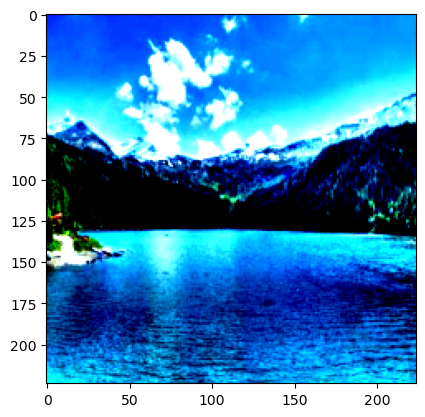

In [63]:
for itr, (udata, masks_enc, masks_pred) in enumerate(unsupervised_loader):
    img = udata[0][0].permute(1, 2, 0)
    plt.imshow(img)
    embed = encoder(udata[0][0].to("cuda:0").unsqueeze(0))
    print(embed)
    break

In [65]:
torch.save(encoder, 'mickeyencoder.pth')